<a href="https://colab.research.google.com/github/VitorPaes/hackathon_stn/blob/master/Hackathon_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomendação para micro e pequenas empresas de turismo

Desafio Hackathon Data Challenge Santander
02/08/2020

Time 35
1. Amanda
1. Hermes
1. Paola
4. Vinícius Rios Fuck
1. Vitor


# Objetivo
Desenvolver um sistema de recomendação para colaborar com os negócios das micro e pequenas empresas do setor de turismo afetadas pela COVID-19, que já tenham sido certificadas com o Selo Turismo Responsável.

# Contextualização

In [1]:
# Load/install required packages
import random

from collections import Counter
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Dashboards
!pip install plotly==4.9.0

# Static figures to show on GitHub
!pip install kaleido==0.0.1
!pip install psutil==5.7.2

import plotly.express as px


## Planilha com estatísticas básicas de turismo 2018

O setor turístico brasileiro vinha em franco crescimento no século XXI. Motivos para isso são maior desenvolvimento, estruturação e incentivos, eventos, tais como Pan-Americano, Olimpíada e Copa do Mundo, globalização e popularização do país como destino por países da Europa.

Uma forma de se ver isso é através dos [dados](http://dadosefatos.turismo.gov.br/images/demanda/Estatisticas_Basicas_2017_2018.xlsx) fornecidos pelo Ministério do Turismo em 2018.

In [2]:
url = 'http://dadosefatos.turismo.gov.br/images/demanda/Estatisticas_Basicas_2017_2018.xlsx'


DF_list = pd.read_excel(url, None)

df = DF_list['5.2 Oferta hoteleira'].iloc[6:39, 0:10]
df.columns = ["Local","MeioHospedagem_2016","UnidHab_2016","Leitos_2016",
              "MeioHospedagem_2017","UnidHab_2017","Leitos_2017",
              "MeioHospedagem_2018","UnidHab_2018","Leitos_2018"]

for col in list(df.columns):
  try:
    df[col] = df[col].str.strip()
  except:
    pass

df["GeoClass"] = "Estado"
df["GeoClass"].iloc[0] = "País"
df["GeoClass"].loc[df["Local"].isin(["Norte", "Nordeste", "Sudeste",
                                     "Sul", "Centro-Oeste"])] = "Região"


,Ano,Total
5,2000,5.41765e+06
6,2001,4.99042e+06
7,2002,4.63011e+06
8,2003,5.37535e+06
9,2004,6.18521e+06
10,2005,6.78823e+06
11,2006,6.36718e+06
12,2007,6.44515e+06
13,2008,6.53426e+06
14,2009,6.51095e+06


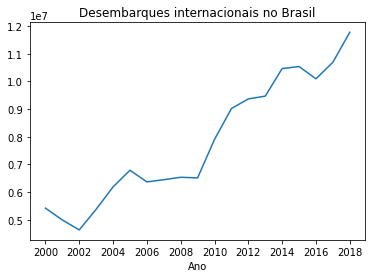

In [3]:
df = DF_list['4.1_Desesmbarque Internacional'].iloc[5:24, 0:2]

df.columns = ["Ano","Total"]
df.plot("Ano","Total", legend=False)
plt.xticks(range(2000,2019,2))
plt.title("Desembarques internacionais no Brasil")
df

## Dados de voos Anac 2020

Para se entender os efeitos da pandemia, podemos continuar analisando dados de voos. Agora da [Agência Nacional da Aviação Civil](https://render.githubusercontent.com/view/ipynb?commit=091340b2e3d986a82325ecdeee26b08fc79f22fb&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f5669746f72506165732f6861636b6174686f6e5f73746e2f303931333430623265336439383661383233323565636465656532366230386663373966323266622f4861636b6174686f6e5f7374642e6970796e62&nwo=VitorPaes%2Fhackathon_stn&path=Hackathon_std.ipynb&repository_id=284154364&repository_type=Repository), para os meses de Março e Abril de 2019 em comparação com Marco e Abril de 2020, podemos ver uma grande queda no número de voos internacionais associada à COVID-19.

In [4]:
url_1 = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/base_voos_agrupados/2019_03.csv' # Turismo responsavel pos-covid
url_2 = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/base_voos_agrupados/2019_04.csv'
url_3 = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/base_voos_agrupados/2020_03.csv'
url_4 = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/base_voos_agrupados/2020_04.csv'
df_2019_03 = pd.read_csv(url_1, header=5, sep=",")
df_2019_03.columns = ['Pais','Voos']
df_2019_04 = pd.read_csv(url_2, header=5, sep=",")
df_2019_04.columns = ['Pais','Voos']
df_2020_03 = pd.read_csv(url_3, header=5, sep=",")
df_2020_03.columns = ['Pais','Voos']
df_2020_04 = pd.read_csv(url_4, header=5, sep=",")
df_2020_04.columns = ['Pais','Voos']

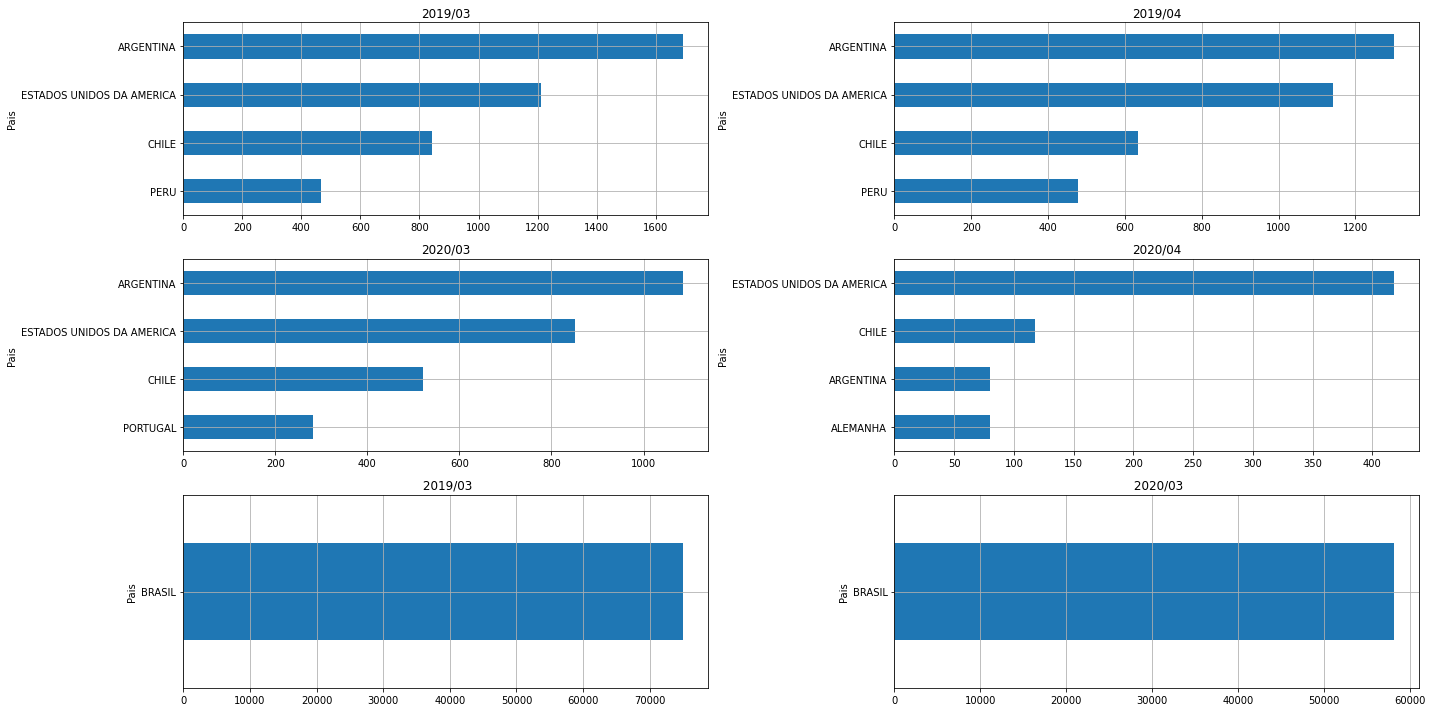

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))

df_2019_03.sort_values(by=['Voos'],ascending=False)[1:5].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[0,0],title='2019/03').grid()
df_2019_04.sort_values(by=['Voos'],ascending=False)[1:5].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[0,1],title='2019/04').grid()
df_2020_03.sort_values(by=['Voos'],ascending=False)[1:5].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[1,0],title='2020/03').grid()
df_2020_04.sort_values(by=['Voos'],ascending=False)[1:5].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[1,1],title='2020/04').grid()
df_2020_04.sort_values(by=['Voos'],ascending=False)[1:5].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[1,1],title='2020/04').grid()
df_2019_04.sort_values(by=['Voos'],ascending=False)[1:5].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[0,1],title='2019/04').grid()
df_2019_03.sort_values(by=['Voos'],ascending=False)[0:1].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[2,0],title=' 2019/03').grid()
df_2020_03.sort_values(by=['Voos'],ascending=False)[0:1].plot.barh(x='Pais',y= 'Voos',legend=False,ax=axs[2,1],title=' 2020/03').grid()
axs[0,0].invert_yaxis()
axs[0,1].invert_yaxis()
axs[1,0].invert_yaxis()
axs[1,1].invert_yaxis()
axs[2,0].invert_yaxis()

fig.tight_layout()

## Caged
Tudo isso culminou em um triste resultado. A crise no setor de turismo e consequente demissão massiva no setor. Para analisar isso, utiliza-se base do [Caged](http://pdet.mte.gov.br/novo-caged). Este faz parte do Programa de Disseminação das Estatísticas do Trabalho do Ministério do Trabalho e fornece dados de desemprego. Pode se monitorar os efeitos da pandemia ao se analisar os saldos de contratações vs demissões no ano de 2020.

A problemática do setor de turismo é evidenciada, pois foram extintos 280.017 empregos no setor de Alojamento e alimentação no Brasil apenas em 2020.

Ao se observar os estados mais afetados (apenas no setor de Alojamento e alimentação), novamente se constata a presença dos estados do Sudeste, Sul e Nordeste. O que corrobora que esses locais concentram o turismo nacional.

In [6]:
url = 'https://github.com/VitorPaes/hackathon_stn/blob/master/dataset/2006_dadosCaged.xlsx?raw=true'
DF_list = pd.read_excel(url, None)


Saldo acumulado 2020:  -280017


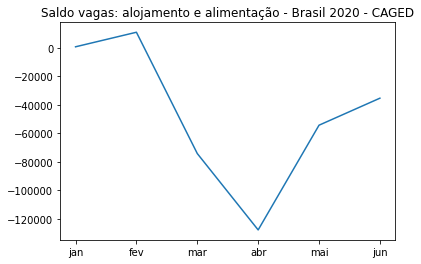

In [7]:
import numpy as np
df = DF_list['Tabela 6'].iloc[4:33, 1:131]
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)
df.index = df.iloc[:,0]
df.columns = df.columns.fillna('to_drop')
df.drop('to_drop', axis = 1, inplace = True)

df_red = df.loc[["Alojamento e alimentação"]].drop(columns=["Admissões", "Estoque", "Desligamentos", "Variação Relativa (%)"])
df_red.columns=["jan","fev","mar","abr","mai","jun","jul","ago","set","out","nov","dez",2020]
df_red.iloc[0,6:12]=np.nan
df_red = df_red.T
df_red
plt.plot(df_red["Alojamento e alimentação"].iloc[0:6])
plt.title("Saldo vagas: alojamento e alimentação - Brasil 2020 - CAGED");
print("Saldo acumulado 2020: ", int(df_red.min()))

In [8]:
df = DF_list['Tabela 4'].iloc[4:33, 1:31]
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)
df.index = df.iloc[:,0]
df.columns = df.columns.fillna('to_drop')
df.drop('to_drop', axis = 1, inplace = True)
df.loc["Alojamento e alimentação"].sort_values()

4
Total                  -35340
São Paulo              -10412
Rio de Janeiro          -6726
Minas Gerais            -3348
Paraná                  -2102
Rio Grande do Sul       -1778
Bahia                   -1652
Santa Catarina          -1577
Goiás                   -1342
Distrito Federal        -1068
Pernambuco              -1001
Espírito Santo           -705
Ceará                    -590
Alagoas                  -475
Rio Grande do Norte      -408
Mato Grosso              -363
Piauí                    -288
Mato Grosso do Sul       -284
Sergipe                  -247
Rondônia                 -222
Paraíba                  -159
Maranhão                 -159
Pará                     -142
Amazonas                 -106
Tocantins                 -59
Roraima                   -49
Acre                      -48
Amapá                     -29
Não identificado           -1
Name: Alojamento e alimentação, dtype: object

## Selo turismo responsável 
Para tentar se reerguer, o Poder Executivo está tentando formas de tratar a problemática do turismo pós-COVID. Um dessas ações foi a criação do Selo Turismo Responsável. Este é uma certificação concedida pelo Governo Federal aos empreendimentos que seguem os protocolos estabelecidos para prevenção da COVID-19.

Tais empresas poderiam ser o espaço amostral para serem selecionadas para um sistema de recomendação, pois os proprietários estão conscientes da problemática da COVID-19.

Os [dados](http://www.turismo.gov.br/seloresponsavel/dados/TurismoResponsavelDadosAbertos.csv) são abertos e podem ser consultados online através do site do Ministério do Turismo.

Nota-se predomínio dos estados do Sudeste, como provável causa tem-se a maior população dessa região. Também há presença forte de estados do Sul, possível que seja devido à maior integração do setor turístico nessa região. A seguir vem os estados do Nordeste, um típico destino turístico nacional.

In [9]:
url = 'http://www.turismo.gov.br/seloresponsavel/dados/TurismoResponsavelDadosAbertos.csv'  # Turismo responsavel pos-covid
df = pd.read_csv(url, header=5, sep=";")
df["UF"].value_counts()


São Paulo              2837
Rio de Janeiro         1805
Minas Gerais           1056
Bahia                   874
Rio Grande do Sul       652
Santa Catarina          581
Paraná                  573
Rio Grande do Norte     554
Pernambuco              509
Ceará                   454
Alagoas                 446
Maranhão                294
Espírito Santo          226
Goiás                   217
Pará                    159
Distrito Federal        146
Paraíba                 140
Mato Grosso do Sul      139
Amazonas                130
Mato Grosso             116
Sergipe                 108
Piauí                    93
Tocantins                47
Rondônia                 29
Roraima                  15
Amapá                     8
Acre                      4
Name: UF, dtype: int64

Observa-se também predomínio das Agências de Turismo e hospedagens nas empresas certificadas.

In [10]:
df["Atividade"].value_counts()

Agência de Turismo                                                  4417
Meio de Hospedagem                                                  3643
Transportadora Turística                                            1474
Restaurante, Cafeteria, Bar e Similares                              847
Prestador Especializado em Segmentos Turísticos                      592
Organizadora de Eventos                                              452
Guia de Turismo                                                      271
Prestador de Infraestrutura de Apoio para Eventos                    143
Locadora de Veículos para Turistas                                   136
Parque Aquático e Empreendimento de Lazer                             67
Acampamento Turístico                                                 45
Parque Temático                                                       44
Empreendimento de Apoio ao Turismo Náutico ou à Pesca Desportiva      31
Centro de Convenções                               

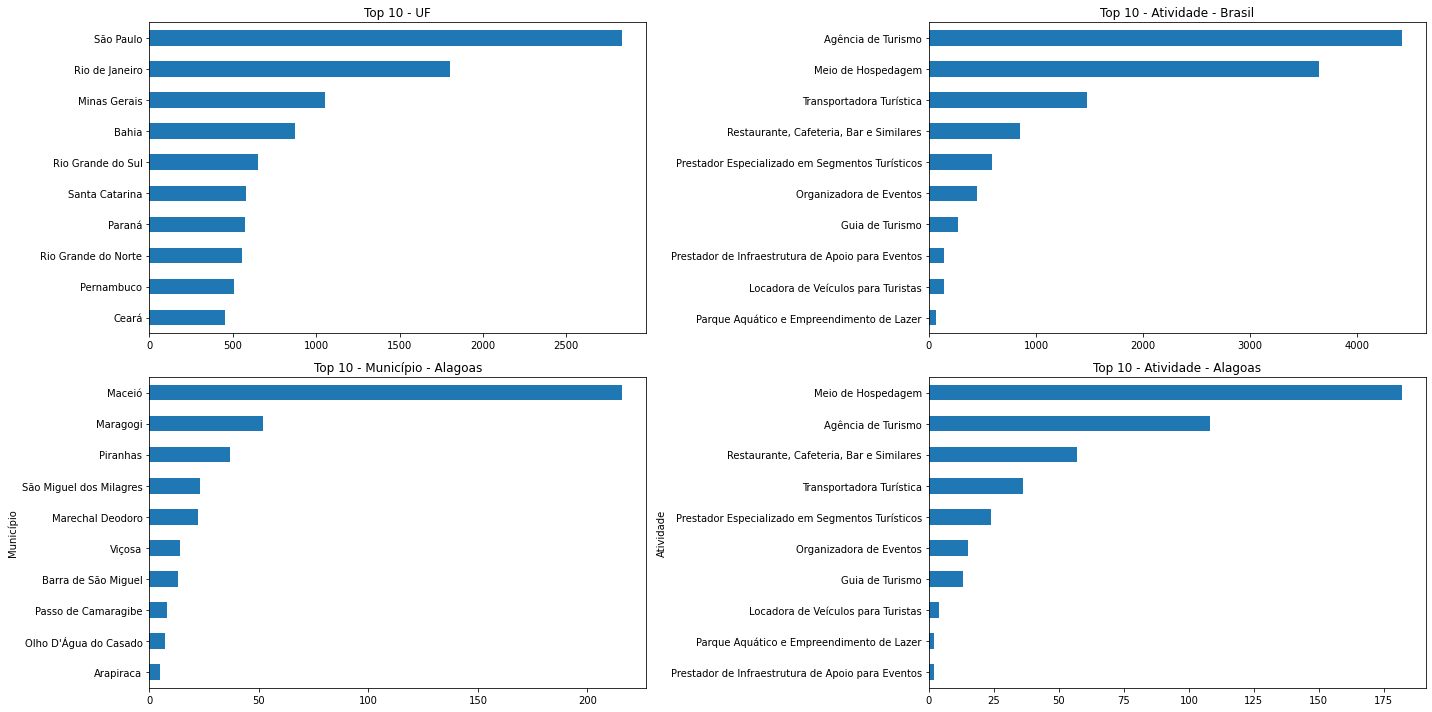

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
col = "UF"
df[col].value_counts().nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[0,0],
                                          title='Top 10 - '+col)

col = "Atividade"
df[col].value_counts().nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[0,1],
                                          title='Top 10 - '+col+" - Brasil")

df.groupby(by=["UF", col]).count().iloc[:,0].loc['Alagoas'].nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[1,1],
                                          title='Top 10 - '+col+" - Alagoas")

col = "Município"
df.groupby(by=["UF", col]).count().iloc[:,0].loc['Alagoas'].nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[1,0],
                                          title='Top 10 - '+col+" - Alagoas")

axs[0,0].invert_yaxis()
axs[0,1].invert_yaxis()
axs[1,0].invert_yaxis()
axs[1,1].invert_yaxis()

fig.tight_layout()

In [13]:
fig = px.treemap(df, path=['UF'], 
                 color_continuous_scale='RdBu',
                 title='Empresas com Selo Turismo Responsável por UF')
fig.show()

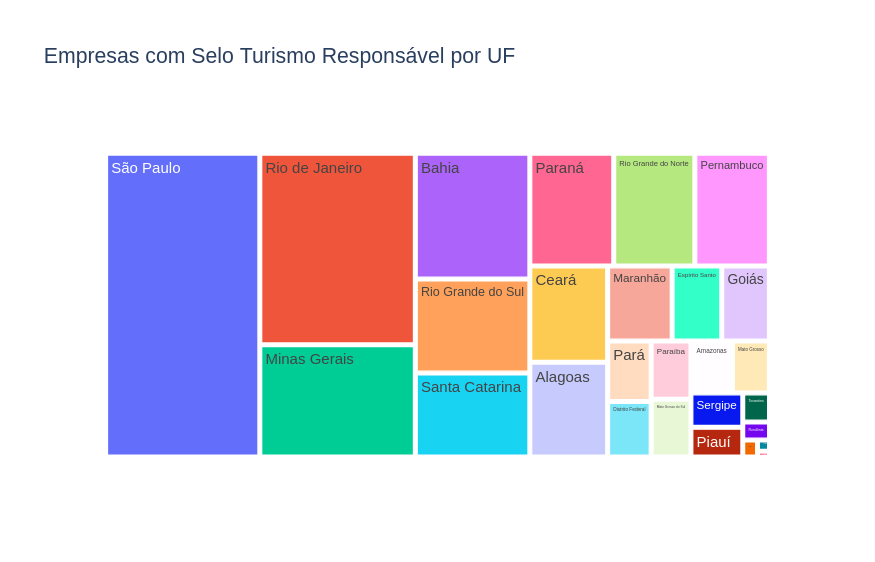

In [14]:
fig.show('png', scale=1.25)  # static, to show on Github

In [15]:
fig = px.treemap(df, path=['Atividade'], 
                 color_continuous_scale='RdBu',
                 title='Empresas com Selo Turismo Responsável por Atividade')
fig.show()

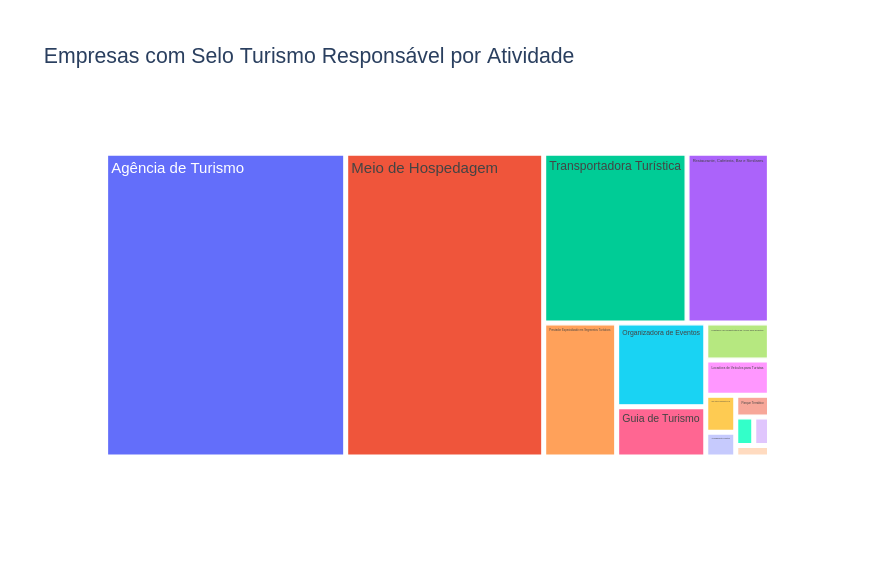

In [16]:
fig.show('png', scale=1.25)   # static, to show on Github

## Tableau brasil.io

Mesmo com essas iniciativas é de extrema importância um ativo monitoramento da situação da doença no país.

A plataforma [Brasil.io](https://brasil.io/home/) é uma força tarefa de 40 voluntários que compila e disponibiliza dados da Covid-19 atualizados diariamente com boletins das 27 Secretarias Estaduais de Saúde. A seguir pode ser visto um exemplo de visualização dos casos para o estado do Alagoas.

O monitoramento dos dados da COVID é essencial para estabelecer medidas preventivas e corretivas de combate à disseminação da doença. O uso de uma ferramenta visual como essa possibilita ao usuário identificar os riscos associados a uma eventual viagem para certos destinos e deve ser ativamente monitorado pelo provável turista.

In [17]:
%%html
<div class='tableauPlaceholder' id='viz1596311061648' style='position: relative'><noscript>
  <a href='#'>
    <img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas&#47;1_rss.png' style='border: none' />
    </a></noscript>
  <object class='tableauViz'  style='display:none;'>
    <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
  <param name='embed_code_version' value='3' />
  <param name='path' value='views&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas?:language=pt&amp;:embed=y&amp;:display_count=y' />
  <param name='toolbar' value='yes' />
  <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas&#47;1.png' />
  <param name='animate_transition' value='yes' />
  <param name='display_static_image' value='yes' />
  <param name='display_spinner' value='yes' />
  <param name='display_overlay' value='yes' />
  <param name='display_count' value='yes' />
  <param name='language' value='pt' />
  </object></div>
  <script type='text/javascript'>
  var divElement = document.getElementById('viz1596311061648');
  var vizElement = divElement.getElementsByTagName('object')[0];
  if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';
  vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} 
  else if ( divElement.offsetWidth > 500 ) 
  { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';}
   else { vizElement.style.width='100%';vizElement.style.height='1227px';}
  var scriptElement = document.createElement('script');
  scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';
  vizElement.parentNode.insertBefore(scriptElement, vizElement);
  </script>

Visualização estática para o GitHub

![](https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/Monitor%20Covid-19%20-%20Alagoas.png)

# Sistema de recomendação

Com todos esses aspectos levantados, nota-se uma crise acentuada no setor de turismo, risco iminente da doença, dessa forma pode-se propor alternativas que ajudem empresas do setor a se reeguerem.

Uma forma de fomentar o turismo nessas regiões e colaborar para as micro e pequena empresas reagirem ao pós-pandemia é propor serviços que recomendem destinos nacionais aos usuários.

Para iniciar uma base de dados para um sistema de recomendação, foram gerados 50 nomes aleatórios na [plataforma](http://listofrandomnames.com/index.cfm?generated).

A pesquisa da [demanda turística internacional de 2018](http://dadosefatos.turismo.gov.br/2016-02-04-11-54-03/demanda-tur%C3%ADstica-internacional.html) foi conduzida pelo Ministério do Turismo, com entrevista direta no momento do término da viagem (aeroportos, fronteiras terrestres) com 39,811 turistas durante uma-duas semanas em diferentes períodos do ano para mitigar os efeitos de sazonalidade. Este dado foi usado como entrada para estimar as distribuições de probabilidade de motivo principal da viagem, motivação da viagem de lazer e hospedagens.
Apresenta-se como limitação ter considerado um dado internacional, pois a distribuição da demanda doméstica provavelmente será diferente e tal demanda é consideravelmente maior. Contudo, utilizou-se esse dado por não dispor de dados de demanda turística nacional do Ministério do Turismo posteriores a 2012.

Tais dados forneceram probabilidades de
* motivo principal da viagem
* motivação da viagem de lazer
* tipos de hospedagem


In [18]:
# Fonte: List of Random Names

nomes_lista = ["Winford", "Christal", "Ellamae", "Tammara", "Alisa",
"Jenise", "Markita","Marcela", "Catrina", "Armida",
"Alayna", "Diego", "Chasity", "Elina", "Neely",
"Darlene", "Raina", "Thu", "Wilton", "Floy",
"Carlita", "Jami", "Joye", "Luana", "Nikita",
"Jerome", "Otto", "Sherika", "Dena", "Bryon", "Ewa",
"Rosalva", "Roseline", "Suzan", "Deloris", "Jinny",
"Victorina", "Albertine", "Luanna", "Toby", "Kara",
"Shan", "Deane", "Sammy", "Ginger", "Audra",
"Dorinda", "Colene", "Anh", "Beatris"]


# Fonte: Demanda Turística Internacional 2018

motivo_lista = ["Lazer", "NegociosEventosConvencoes", "VisitarAmigosParentes",
                 "EstudoCursos", "Saude", "Religiao", "Compras", "Outros"]
motivo_prob = [0.588, 0.135, 0.241, 0.016, 0.004, 0.004, 0.001, 0.011]

hospedagem_lista = ["Hotel", "Casa_Amigo_Parente", "Casa_Alugada",
                    "Camping_Albergue", "CasaPropria", "Outros"]

hospedagem_prob = [0.488, 0.249, 0.159, 0.047, 0.027, 0.03]

lazer_lista = ["Sol_Praia", "Natureza_Ecoturismo_Aventura", "Cultura",
               "Esportes", "Diversao_Noturna", "ViagemIncentivo", "Outros"]
lazer_prob = [0.717, 0.163, 0.095, 0.016, 0.004, 0.002, 0.003]


## TODO 
# DICIONARIO COM TERMOS SIMILARES
# ex: Ecoturismo: natureza



In [19]:
def gera_amostras(nomes_lista, motivo_lista, lazer_lista, hospedagem_lista,
                  motivo_prob, lazer_prob, hospedagem_prob,
                  num_simulations = 49):
  usuarios = []
  motivo_tipos = []
  lazer_tipos = []
  hospedagem_tipos =[]
  
  for i in range(num_simulations):
    usuarios.append({"id": i, "name": nomes_lista[i]})

    motivo_sample = random.choices(motivo_lista, motivo_prob)[0]
    motivo_tipos.append((i, motivo_sample))
    motivo_sample = random.choices(motivo_lista, motivo_prob)[0]
    motivo_tipos.append((i, motivo_sample))
    motivo_sample = random.choices(motivo_lista, motivo_prob)[0]
    motivo_tipos.append((i, motivo_sample))

    hospedagem_sample = random.choices(hospedagem_lista, hospedagem_prob)[0]
    hospedagem_tipos.append((i, hospedagem_sample))
    hospedagem_sample = random.choices(hospedagem_lista, hospedagem_prob)[0]
    hospedagem_tipos.append((i, hospedagem_sample))
    hospedagem_sample = random.choices(hospedagem_lista, hospedagem_prob)[0]
    hospedagem_tipos.append((i, hospedagem_sample))

    if motivo_sample == "Lazer":
      lazer_sample = random.choices(lazer_lista, lazer_prob)[0]
      lazer_tipos.append((i, random.choice(lazer_lista)))
      lazer_sample = random.choices(lazer_lista, lazer_prob)[0]
      lazer_tipos.append((i, random.choice(lazer_lista)))
      lazer_sample = random.choices(lazer_lista, lazer_prob)[0]
      lazer_tipos.append((i, random.choice(lazer_lista)))
    else:
      lazer_tipos.append((i, ""))
  
  
  return usuarios, motivo_tipos, hospedagem_tipos, lazer_tipos


Para implementar o sistema de recomendação foram desenvolvidas algumas funções auxiliares:

* `interest_freq`: contabiliza a frequência que uma palavra ocorre;
* `interest_unique`: identifica e ordena palavras únicas, associando-as a usuários;
* `make_user_vector`: retorna vetor binário para relação usuário x interesse;
* `cosine_similarity`: compara a similiaridade entre dois usuários com uma métrica de coseno;
* `most_similar_users_to`: identifica usuários mais similares;
* `user_based_recommendations`: gera recomendações com base nos usuários mais similares;
* `most_popular_new_interests`: identifica os interesses novos mais populares;
* `recommendations`: faz a recomendação com vetor de probabilidades.

In [20]:
def interest_freq(interest_types, interest_name):
  """
    input: interest_types (list), interest_name (string)
    output: interest_freq (collections.Counter) with frequency of words 

    contabiliza a frequência que uma palavra ocorre
  """
  interest_freq = Counter(word for user_id, interest in interest_types
                           for word in interest.lower().split())
  print("\nTipos de " + interest_name)
  for word, count in interest_freq.most_common():
    if count > 1:
        print(word, count)

  return interest_freq


def interest_unique(interest_types):
  """
    input: interest_types (list)
    output: unique_interest (list),
            interest_by_user_id (collection.defaultdict),
    identifica e ordena palavras únicas,
    associando-as a usuários
  """
  interest_by_user_id = defaultdict(list)
  unique_interest = set()
  
  for user_id, interest in interest_types:
    interest_by_user_id[user_id].append(interest)
    unique_interest.add(interest)

  unique_interest = sorted(list(unique_interest))

  return unique_interest, interest_by_user_id


def make_user_vector(user_id, interest_by_user_id, unique_interest):
    """
      Criar vetor para um determinado usuário (usuário x interesse)

      1 - Se o usuário tem
      0 - Contrário

    """
    return [1 if interest in interest_by_user_id[user_id]
            else 0 for interest in unique_interest]


def cosine_similarity(v, w):
  """
      Compara dois usuários    
  """
  return np.dot(v, w) / np.sqrt(np.dot(v, v) * np.dot(w, w))


def most_similar_users_to(user_id, users_sim_matrix):
    pairs = [(other_user_id, similarity)
            for other_user_id, similarity in enumerate(users_sim_matrix[user_id])
             if user_id != other_user_id and similarity > 0
            ]
    return sorted(pairs, key=lambda x: -x[1])


def user_based_recommendations(user_id, interest_by_user_id, unique_interest,
                               include_current_interests=False):
    """
        Gerar recomendação baseado nos usuários mais similares

    """

    # Usuários x interesses
    users_matrix = [make_user_vector(user, interest_by_user_id, unique_interest)
                for user in interest_by_user_id]
    # print(users_matrix)
    # Similaridade
    users_sim_matrix = [[cosine_similarity(interest_vector_v, interest_vector_w) 
                     for interest_vector_w in users_matrix] 
                    for interest_vector_v in users_matrix]
    # print(users_sim_matrix)

    ## Usuários mais similares ao usuário
    # most_similar_users_to(0)
    
    ## Lista de interesses do usuário
    # print(interest_by_user_id[0])

    predictions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id,
                                                           users_sim_matrix):
      for interest in interest_by_user_id[other_user_id]:
        # Para cada interesse soma-se a similaridade dos usuários mais proxímos
        predictions[interest] += similarity

    predictions = sorted(predictions.items(), key=lambda x: -x[1])

    # print(predictions)
    # print(interest_by_user_id)
    # print(user_id)

    if include_current_interests:
        return predictions
     
    else:
        return [(prediction, round(score,2)) 
            for prediction, score in predictions
                if prediction not in interest_by_user_id[user_id]]
    

def most_popular_new_interests(user_interests, popular_interests, max_results=5):
    recommendations = [
        (interest, frequency)
        for interest, frequency in popular_interests.items()

        if interest not in user_interests
                      ]
    return sorted(recommendations[:max_results], key=lambda x: -x[1])


def recommendation(users, interest_by_user_id, user_sampled):
  most_common_interest = Counter(interest for user in users 
                            for interest in interest_by_user_id[user['id']])
  print("\nRecomendações para %s (mais populares):: %s " 
      % (users[user_sampled]['name'],
         most_popular_new_interests(interest_by_user_id[user_sampled],
                                    most_common_interest)))
  # TODO remover print "" de tipos de lazer quando não for lazer

  return most_common_interest

Para testar, geram-se amostras e seleciona-se aleatoriamente um usuário.

In [21]:
num_simulations = len(nomes_lista)
(usuarios, motivo_tipos, hospedagem_tipos, lazer_tipos) = \
      gera_amostras(nomes_lista, motivo_lista, lazer_lista, hospedagem_lista,
                    motivo_prob, lazer_prob, hospedagem_prob,
                    num_simulations)


In [22]:
num_simulations = len(usuarios)
usuario_amostra = random.randint(0,num_simulations)
usuario_amostra

47

A seguir, observam-se as respostas mais frequentes, recomendações para o usuário e predição (motivo, interesse por lazer e hospedagem).

In [23]:
motivo_freq = interest_freq(motivo_tipos, 'motivo')
motivo_unico, motivo_por_id_usuario = interest_unique(motivo_tipos)
popular_motivo = recommendation(usuarios, motivo_por_id_usuario, usuario_amostra)

user_based_pred = user_based_recommendations(usuario_amostra,
                                             motivo_por_id_usuario, motivo_unico)
print("\nProváveis opções mais similares ao perfil do usuário: ", user_based_pred)


Tipos de motivo
lazer 89
visitaramigosparentes 37
negocioseventosconvencoes 18
estudocursos 3
religiao 2

Recomendações para Colene (mais populares):: [('EstudoCursos', 3), ('Religiao', 2), ('Compras', 1)] 

Prováveis opções mais similares ao perfil do usuário:  [('EstudoCursos', 1.48), ('Religiao', 1.33), ('Compras', 0.67)]


In [24]:
lazer_freq = interest_freq(lazer_tipos, 'lazer')
lazer_unico, lazer_por_id_usuario = interest_unique(lazer_tipos)
popular_lazer = recommendation(usuarios, lazer_por_id_usuario, usuario_amostra)

user_based_pred = user_based_recommendations(usuario_amostra,
                                             lazer_por_id_usuario, lazer_unico)
print("\nProváveis opções mais similares ao perfil do usuário: ", user_based_pred)


Tipos de lazer
natureza_ecoturismo_aventura 17
sol_praia 17
diversao_noturna 15
viagemincentivo 14
esportes 13
outros 12
cultura 11

Recomendações para Colene (mais populares):: [('Natureza_Ecoturismo_Aventura', 17), ('', 17), ('Esportes', 13), ('Outros', 12), ('Cultura', 11)] 

Prováveis opções mais similares ao perfil do usuário:  [('Esportes', 4.9), ('ViagemIncentivo', 4.13), ('Natureza_Ecoturismo_Aventura', 3.04), ('Outros', 3.04), ('Cultura', 2.63)]


In [25]:
hospedagem_freq = interest_freq(hospedagem_tipos, 'hospedagem')
hospedagem_unico, hospedagem_por_id_usuario = interest_unique(hospedagem_tipos)
popular_hospedagem = recommendation(usuarios,
                                    hospedagem_por_id_usuario, usuario_amostra)

user_based_pred = user_based_recommendations(usuario_amostra,
                                             hospedagem_por_id_usuario,
                                             hospedagem_unico)
print("\nProváveis opções mais similares ao perfil do usuário: ", user_based_pred)


Tipos de hospedagem
hotel 69
casa_amigo_parente 41
casa_alugada 25
camping_albergue 8
outros 5
casapropria 2

Recomendações para Colene (mais populares):: [('Casa_Amigo_Parente', 41), ('Casa_Alugada', 25), ('Camping_Albergue', 8), ('Outros', 5), ('CasaPropria', 2)] 

Prováveis opções mais similares ao perfil do usuário:  [('Casa_Amigo_Parente', 21.46), ('Casa_Alugada', 14.07), ('Camping_Albergue', 3.15), ('Outros', 2.44), ('CasaPropria', 0.58)]


In [31]:
#TODO Métricas Pares
todos = []
for i in range(num_simulations):
  todos.append(list([nomes_lista[i]])+list(motivo_tipos[i])+list(lazer_tipos[i])+list(hospedagem_tipos[i]))
df = pd.DataFrame(todos)
df = df.drop(columns=[1,3,5])
df

,0,2,4,6
0,Winford,NegociosEventosConvencoes,Esportes,Hotel
1,Christal,Lazer,Natureza_Ecoturismo_Aventura,Casa_Amigo_Parente
2,Ellamae,Lazer,Natureza_Ecoturismo_Aventura,Hotel
3,Tammara,Lazer,Natureza_Ecoturismo_Aventura,Casa_Amigo_Parente
4,Alisa,NegociosEventosConvencoes,Outros,Casa_Amigo_Parente
5,Jenise,Lazer,Esportes,Hotel
6,Markita,VisitarAmigosParentes,Outros,Hotel
7,Marcela,Compras,Sol_Praia,Hotel
8,Catrina,Lazer,Sol_Praia,Casa_Alugada
9,Armida,NegociosEventosConvencoes,,Casa_Amigo_Parente


## Planilha de turismo do Alagoas

Em um primeiro momento, optou-se por limitar o estudo ao estado do Alagoas, tendo em vista que foi encontrada uma [base](http://dados.al.gov.br/dataset/61a00d24-d63e-430d-b1fa-19cc89d2f549/resource/08e685b9-d1ef-438d-906a-50808017f26e) que permite visualizar os principais destinos turísticos e explorar o potencial do sistema de recomendação. 

In [27]:
url = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/convertcsv3.csv'
df = pd.read_csv(url, sep=";", encoding='latin')

for col in ['Nome', 'Município', "Segmento"]:
  df[col] = df[col].str.strip()

col = "Segmento"
df[col] = df[col].str.replace("Sol e Praia", "Sol_Praia")
df[col] = df[col].str.replace("Histórico/Cultural", "Cultura")
df[col] = df[col].str.replace("Ecoturismo/Aventura/Sol_Praia",
                              "Natureza_Ecoturismo_Aventura")
df[col] = df[col].str.replace("Ecoturismo/Aventura",
                              "Natureza_Ecoturismo_Aventura")

# TODO: Encodar tipos de estabelecimento
hospedagem_lista = ["Hotel", "Casa_Amigo_Parente", "Casa_Alugada",
                    "Camping_Albergue", "CasaPropria", "Outros"]

col = "Município"
df[col] = df[col].str.replace("-AL","")

col = "Distância da Capital (km)" 
df[col] = df[col].str.replace(",",".").astype('float')

col = "Tempo de condução estimado" 
df[col] = df[col].str.replace(".","")
df[col] = df[col].str.replace("minutos","min")
df[col] = df[col].str.replace(" ","")
df[col] = df[col].str.replace("he",":")

df[col] = df[col].str.replace(r"^([0-9]+)min","00:\\1")
df[col] = df[col].str.replace(r"([0-9]+)h$","\\1:00")
df[col] = df[col].str.replace("min","")
df[col] = df[col].str.replace("^([0-9]):","0\\1:")
df[col] = df[col].str.replace(":([0-9])$",":0\\1")

col = "Latitude" 
df[col] = df[col].astype('str').str.replace(".","")
df[col] = df[col].str.replace("^-9","-9.")
df[col] = df[col].str.replace("^-10","-10.").astype('float')

col = "Longitude"
df[col] = df[col].astype('str').str.replace(".","")
df[col] = df[col].str.replace("^-3","-3.").astype('float')

col = "Segmento"
df[col].value_counts()

Sol_Praia                       56
Cultura                         17
Natureza_Ecoturismo_Aventura     7
Name: Segmento, dtype: int64

## Banco de consulta destinos turísticos Alagoas

Para permitir ao usuário consultar os destinos turísticos de Alagoas, fez-se essa tabela com filtros para seleção (inicialmente interativa apenas em Google Colaboratory).

In [28]:
%load_ext google.colab.data_table
df.drop(["Latitude", "Longitude"],axis=1)

,Nome,Município,Distância da Capital (km),Tempo de condução estimado,Segmento
0,Foz do Rio São Francisco AL - SE,Piaçabuçu,142.0,02:07,Sol_Praia
1,Praia do Francês,Marechal Deodoro,21.7,00:25,Sol_Praia
2,Reserva Marituba do Peixe,Penedo / Piaçabuçu / Feliz Deseto,130.0,02:00,Natureza_Ecoturismo_Aventura
3,Angiquinho,Delmiro Gouveia,330.0,04:00,Cultura
4,Porto Calvo ( Terra de Calabar),Porto Calvo,96.0,01:30,Cultura
...,...,...,...,...,...
75,Estação Ecológica de Murici,Murici,60.0,01:00,Natureza_Ecoturismo_Aventura
76,Centro Historico de Jaraguá,Maceió,NaN,NaN,Cultura
77,Barra Mar,Barra de São Miguel,35.7,00:38,Sol_Praia
78,Piscinas Naturais de Paripueira,Paripueira,29.4,00:31,Sol_Praia


## Banco de consulta empresas certificadas pelo Selo Turismo Responsável


Para permitir ao usuário consultar as empresas certificadas com o Selo Turismo Responsável, fez-se essa tabela com filtros para seleção (inicialmente interativa apenas em Google Colaboratory).

In [41]:
%unload_ext google.colab.data_table
url = 'http://www.turismo.gov.br/seloresponsavel/dados/TurismoResponsavelDadosAbertos.csv'  # Turismo responsavel pos-covid
df = pd.read_csv(url, header=5, sep=";")
x = (df[df["UF"]=="Alagoas"]
 .drop(["CNPJ", "Razão Social"], axis=1))
x["Atividade"].value_counts()

The google.colab.data_table extension is not loaded.


Meio de Hospedagem                                                  182
Agência de Turismo                                                  108
Restaurante, Cafeteria, Bar e Similares                              57
Transportadora Turística                                             36
Prestador Especializado em Segmentos Turísticos                      24
Organizadora de Eventos                                              15
Guia de Turismo                                                      13
Locadora de Veículos para Turistas                                    4
Prestador de Infraestrutura de Apoio para Eventos                     2
Parque Aquático e Empreendimento de Lazer                             2
Empreendimento de Apoio ao Turismo Náutico ou à Pesca Desportiva      1
Acampamento Turístico                                                 1
Casa de Espetáculos e Equipamento de Animação Turística               1
Name: Atividade, dtype: int64

In [42]:
%load_ext google.colab.data_table
df

,UF,Município,Data,Atividade,CNPJ,Razão Social,Nome Fantasia
0,Goiás,Pirenópolis,03/06/2020 20:33:04,Meio de Hospedagem,⠀12027621000148,DIVINA POUSADA E EVENTOS LTDA,DIVINA POUSADA E EVENTOS
1,São Paulo,Itatiba,04/06/2020 10:28:28,Agência de Turismo,⠀52351640000140,ITATIBATUR AGENCIA DE VIAGENS S/C LTDA,ITATIBATUR AGÊNCIA DE VIAGENS S/C LTDA
2,São Paulo,Itatiba,04/06/2020 10:30:26,Agência de Turismo,⠀52351640000140,ITATIBATUR AGENCIA DE VIAGENS S/C LTDA,ITATIBATUR AGÊNCIA DE VIAGENS S/C LTDA
3,São Paulo,Itatiba,04/06/2020 10:31:30,Prestador Especializado em Segmentos Turísticos,⠀52351640000140,ITATIBATUR AGENCIA DE VIAGENS S/C LTDA,ITATIBATUR AGÊNCIA DE VIAGENS S/C LTDA
4,São Paulo,Itatiba,04/06/2020 10:33:06,Agência de Turismo,⠀52351640000220,ITATIBATUR AGENCIA DE VIAGENS S/C LTDA,CVC Itatiba Shopping
...,...,...,...,...,...,...,...
12207,Goiás,Alto Paraíso de Goiás,02/08/2020 17:52:34,Meio de Hospedagem,⠀30171745000184,POUSADA ARARAS LTDA,POUSADA ARARAS
12208,Rio de Janeiro,Rio de Janeiro,02/08/2020 17:57:14,Agência de Turismo,⠀23405032000172,LUCINEA ALMEIDA DE BARROS 08509736782,NaN
12209,Amazonas,Manaus,02/08/2020 18:05:22,Agência de Turismo,⠀21315878000196,L3 AGENCIA DE VIAGENS E TRANSPORTE LTDA,L3 TRANSPORTE E TURISMO
12210,Amazonas,Manaus,02/08/2020 18:05:43,Transportadora Turística,⠀21315878000196,L3 AGENCIA DE VIAGENS E TRANSPORTE LTDA,L3 TRANSPORTE E TURISMO


Um exemplo de consulta poderia ser `Meios de Hospedagem` em `Marechal Deodoro`.

In [43]:
%unload_ext google.colab.data_table
(df[df["UF"]=="Alagoas"]
 .drop(["CNPJ", "Razão Social"], axis=1)
 .loc[df["Atividade"]=="Meio de Hospedagem"]
 .loc[df["Município"]=="Marechal Deodoro"])


,UF,Município,Data,Atividade,Nome Fantasia
2214,Alagoas,Marechal Deodoro,08/06/2020 09:52:06,Meio de Hospedagem,CAPITÃES DE AREIA
4724,Alagoas,Marechal Deodoro,15/06/2020 18:48:46,Meio de Hospedagem,BLUE VIKING
5796,Alagoas,Marechal Deodoro,18/06/2020 20:06:46,Meio de Hospedagem,LA DOLCE VITA FLAT & POUSADA
6558,Alagoas,Marechal Deodoro,23/06/2020 16:07:36,Meio de Hospedagem,LE SOLEIL - POUSADA E RESTAURANTE
6565,Alagoas,Marechal Deodoro,23/06/2020 16:19:51,Meio de Hospedagem,POUSADA PANORAMA
6693,Alagoas,Marechal Deodoro,24/06/2020 11:49:48,Meio de Hospedagem,POUSADA DO ACONCHEGO
6694,Alagoas,Marechal Deodoro,24/06/2020 11:49:55,Meio de Hospedagem,POUSADA SEMPRE GRACIOSA
9222,Alagoas,Marechal Deodoro,11/07/2020 20:20:31,Meio de Hospedagem,FRANCES PRAIA POUSADA
9329,Alagoas,Marechal Deodoro,13/07/2020 11:36:42,Meio de Hospedagem,HOTEL PONTA VERDE PRAIA DO FRANCES
9355,Alagoas,Marechal Deodoro,13/07/2020 13:41:17,Meio de Hospedagem,HOTEL LUA CHEIA


# Limitações

1. Ressalta-se que essas são análises preliminares;
2. A geração do banco de dados foi artificial baseadas em dados de turismo internacional no Brasil, poderiam ser exploradas técnicas de webscrapping em outras plataformas;
3. As funcionalidades interativas estão restritas à visualização no Google Colaboratory;
4. O sistema de recomendação tem muito potencial de melhoria, foi proposta uma solução simples com agrupamento de perfis mais similares com apenas uma métrica.

# Contribuições

1. Há atualização integrada com transparência e facilidade para monitorar dados da Covid, com inserção de visualização em Tableau gerada pelo Brasil.io
2. Há atualização automática de banco de dados de consulta do cadastro de empresas certificadas com o Selo Turismo Responsável do Governo Federal.
3. Há interatividade à consulta de banco de dados com principais destinos turísticos de Alagoas.
4. Há o início de um sistema de recomendação baseado em dados de turismo internacional no Brasil.
5. Há potencial de customização e parceria com empresas nacionais do segmento turístico, sobretudo micro e média empresas comprometidas com protocolos de prevenção ao COVID-19.
6. Foi proposta uma solução para a problemática (desemprego, desaquecimento do setor) de empresas do setor de turismo, não se esquecendo das medidas preventivas para evitar disseminação descontrolada da COVID-19 em tempos pós-pandemia.
7. Os dados são públicos e o código foi publicado em repositório no GitHub.